In [13]:
import pandas as pd
import os

# 데이터 폴더 경로 설정
data_folder = r'C:\Users\gkrry\AI-Quant\StockClustering\데이터\데이터 수집 및 전처리\data'
parquet_files = [f for f in os.listdir(data_folder) if f.endswith('.parquet')]

print(f"Loading {len(parquet_files)} files...")
all_stocks = []

for file in parquet_files:
    stock_df = pd.read_parquet(os.path.join(data_folder, file))
    
    ticker_code = file.split('_')[0]
    stock_df['Ticker'] = ticker_code
    
    all_stocks.append(stock_df)

df_all = pd.concat(all_stocks)
df_all.index = pd.to_datetime(df_all.index)
df_all.index.name = 'Date'

Loading 200 files...


In [20]:
# df_all

In [16]:
import pandas as pd
from pathlib import Path

# 1) cluster_labels 로드
cluster_path = Path(r"C:\Users\gkrry\AI-Quant\kmeans_outputs\rolling_2024-12-02_to_2024-12-09_20251230_083041\cluster_labels_wide_aligned.csv")
labels_wide = pd.read_csv(cluster_path, dtype={"Ticker": str})

labels_wide["Ticker"] = labels_wide["Ticker"].str.strip().str.zfill(6)

# 2) wide -> long (Ticker, Date, Cluster)
labels_long = labels_wide.melt(id_vars="Ticker", var_name="Date", value_name="Cluster")
labels_long["Date"] = pd.to_datetime(labels_long["Date"]).dt.normalize()
labels_long["Cluster"] = pd.to_numeric(labels_long["Cluster"], errors="coerce").astype("Int64")
labels_long = labels_long.drop_duplicates(subset=["Ticker", "Date"], keep="last")

# 3) df_all 준비 (기존 Cluster 있으면 제거)
df_left = df_all.reset_index().rename(columns={"index": "Date"}).copy()
df_left["Date"] = pd.to_datetime(df_left["Date"]).dt.normalize()
df_left["Ticker"] = df_left["Ticker"].astype(str).str.strip().str.zfill(6)

if "Cluster" in df_left.columns:
    df_left = df_left.drop(columns=["Cluster"])   # <- 이 한 줄이 핵심!

# 4) merge
df_merged = df_left.merge(
    labels_long,
    on=["Ticker", "Date"],
    how="left",
    validate="many_to_one"   # (옵션) labels_long이 (Ticker,Date) 유일하다는 검증
)

# 5) Date 다시 인덱스로
df_cluster = df_merged.set_index("Date").sort_index()

# 6) 매칭률 체크 (df_cluster 기준으로!)
print("Cluster not-null ratio:", df_cluster["Cluster"].notna().mean())
print(df_cluster[["Ticker","Cluster"]].head())


Cluster not-null ratio: 0.0019923615531508595
            Ticker  Cluster
Date                       
2015-01-02  000030     <NA>
2015-01-02  069960     <NA>
2015-01-02  005930     <NA>
2015-01-02  005940     <NA>
2015-01-02  069620     <NA>


In [19]:
# df_cluster
df_cluster_nonnull = df_cluster[df_cluster["Cluster"].notna()]
df_cluster_nonnull

,종목명,Open,High,Low,Close,Volume,Change,Return_1d,Return_5d,Return_20d,...,PER,PBR,ROE,배당성향,ROE_YoY,EPS_YoY,영업이익_YoY,매출액_YoY,Ticker,Cluster
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-02,SK네트웍스,4345,4350,4240,4300,496838,-0.010357,-1.035673,-2.824859,-16.988417,...,20.129201,0.433036,0.021513,140.436289,-7242.975518,-7292.592593,74.870261,13.912708,001740,1
2024-12-02,락앤락,0,0,0,8660,0,0.000000,0.000000,0.000000,0.115607,...,12.997539,0.672980,0.051778,293.120010,-175.374301,-183.824621,-113.854246,-1.721800,115390,2
2024-12-02,오뚜기,413000,414000,402000,403500,2833,-0.023002,-2.300242,1.509434,-3.584229,...,11.830187,0.677817,0.057296,26.387034,-19.005569,-14.740484,-23.404359,-0.503565,007310,0
2024-12-02,삼광글라스,25500,25650,24950,25000,31228,-0.019608,-1.960784,-4.214559,-5.303030,...,5.540842,0.475429,0.085805,37.677722,48.797905,56.726968,-25.995971,-32.362719,005090,1
2024-12-02,고려아연,1235000,1534000,1228000,1411000,133739,0.195763,19.576271,56.256921,30.046083,...,153.531107,3.103941,0.020217,190.417744,-65.060374,-64.828783,-6.507722,39.830633,010130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09,LF,15440,15440,14200,14740,27443,-0.045337,-4.533679,-5.209003,1.166781,...,5.710743,0.270194,0.047313,27.120220,-11.905820,-8.534878,272.263321,15.392167,093050,0
2024-12-09,삼성전자,53500,54600,53200,53400,26227680,-0.012939,-1.293900,-0.373134,-2.909091,...,10.788642,0.921802,0.085442,29.214187,108.526928,132.297230,277.367688,17.349068,005930,1
2024-12-09,현대차,201000,203000,200000,201000,774548,-0.012285,-1.228501,-6.944444,-4.739336,...,4.365599,0.496181,0.113657,26.063279,-10.892782,5.626891,-6.466503,4.725916,005380,0


# 3. 클러스터별 피처 분포 확인

## 3-1. pc loading 상위값 5개 확인 
그 값으로 피쳐의 분포를 확인하면 값을 알 수 있을 것 같다.  

In [28]:
import pandas as pd
from pathlib import Path

def top_pca_loadings(
    csv_path,
    pcs=("PC1", "PC2", "PC3"),
    topn=5,
    mode="abs",            # "abs" or "value"
    feature_col=None,      # None이면 자동 추정(첫 번째 컬럼 또는 index)
    print_result=True
):
    """
    PCA loading CSV에서 PC별 상위 로딩(topn) 항목과 값을 반환.

    Parameters
    ----------
    csv_path : str | Path
        pca_loadings_YYYY-MM-DD.csv 경로
    pcs : tuple[str]
        ("PC1","PC2","PC3") 처럼 PC 이름. CSV 컬럼명에 맞춰 자동 매핑함.
    topn : int
        상위 몇 개를 뽑을지
    mode : str
        "abs"  -> |loading| 큰 순 (추천)
        "value"-> loading 값이 큰 순(양수 큰 순)
    feature_col : str | None
        피처명이 들어있는 컬럼명. None이면 자동 추정.
    print_result : bool
        True면 결과를 화면에 보기 좋게 출력

    Returns
    -------
    result : dict[str, pd.DataFrame]
        예: result["PC1"] = DataFrame(feature, loading)
    """

    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)

    # 1) feature(항목명) 컬럼 자동 추정
    # - 흔히: 첫 컬럼이 "feature" or "Feature" or unnamed index column
    if feature_col is None:
        candidates = ["feature", "Feature", "factor", "Factor", "variable", "Variable", "name", "Name"]
        found = [c for c in candidates if c in df.columns]
        if found:
            feature_col = found[0]
        else:
            # 첫 컬럼이 로딩 컬럼이 아니라면 피처명으로 간주
            first_col = df.columns[0]
            if "PC" not in str(first_col):
                feature_col = first_col
            else:
                feature_col = None  # 피처명이 index로 저장된 형태일 수도 있음

    if feature_col is not None:
        df = df.rename(columns={feature_col: "Feature"})
    else:
        # 피처명이 index로 들어간 CSV일 수 있음
        # (read_csv에서 index를 못 잡았으니, 여기선 그냥 행 번호면 Feature가 없음)
        # 가능하면 'Unnamed: 0'을 Feature로 쓰자
        if "Unnamed: 0" in df.columns:
            df = df.rename(columns={"Unnamed: 0": "Feature"})
        else:
            # 마지막 fallback: index를 Feature로
            df["Feature"] = df.index.astype(str)

    # 2) 로딩 컬럼명 자동 매핑
    # - 파일마다 PC1_loading / PC1 / PC1 (loading) 등 다를 수 있으니 후보를 만든다.
    def find_pc_col(pc):
        candidates = [
            f"{pc}_loading", f"{pc}_Loading", f"{pc}_LOADING",
            pc, pc.lower(), pc.upper(),
            f"{pc} loading", f"{pc} Loading", f"{pc}(loading)", f"{pc} (loading)"
        ]
        for c in candidates:
            if c in df.columns:
                return c
        # 부분일치(예: 'PC1_loading_std' 같은 경우)
        for c in df.columns:
            if str(c).startswith(pc) and "load" in str(c).lower():
                return c
        raise KeyError(f"[{pc}]에 해당하는 로딩 컬럼을 찾지 못했어. 현재 컬럼: {df.columns.tolist()}")

    result = {}
    for pc in pcs:
        pc_col = find_pc_col(pc)

        s = pd.to_numeric(df[pc_col], errors="coerce")
        tmp = pd.DataFrame({"Feature": df["Feature"].astype(str), "loading": s}).dropna()

        # tmp 만들고 난 다음에
        tmp = tmp[~tmp["Feature"].isin(["explained_variance_ratio", "cum_explained", "explained_variance", "cum_explained_variance"])]

        if mode == "abs":
            tmp["_key"] = tmp["loading"].abs()
            tmp = tmp.sort_values("_key", ascending=False).drop(columns="_key")
        elif mode == "value":
            tmp = tmp.sort_values("loading", ascending=False)
        else:
            raise ValueError("mode는 'abs' 또는 'value'만 가능")

        top = tmp.head(topn).reset_index(drop=True)
        result[pc] = top

        if print_result:
            print(f"\n=== {pc} top {topn} ({'|loading|' if mode=='abs' else 'value'} 기준) ===")
            print(top.to_string(index=False))

    return result

In [29]:
top_pca_loadings(
    r"C:\Users\gkrry\AI-Quant\kmeans_outputs\rolling_2024-12-02_to_2024-12-09_20251230_083041\per_date\2024-12-03\pca_loadings_2024-12-03.csv",
    pcs=("PC1", "PC2", "PC3"),
    topn=5,
    mode="abs"
)



=== PC1 top 5 (|loading| 기준) ===
       Feature  loading
Disparity_120d 0.283490
    Zscore_60d 0.274206
    Sharpe_60d 0.270942
    Return_50d 0.267237
        RSI_14 0.266801

=== PC2 top 5 (|loading| 기준) ===
Feature   loading
 ATR_14  0.414611
 vol_60  0.404413
 vol_20  0.368154
    BPS  0.252567
  배당수익률 -0.245171

=== PC3 top 5 (|loading| 기준) ===
             Feature   loading
             NATR_14  0.418653
             log_vol -0.352424
std_log_vol_ratio_60  0.350834
                 PER  0.334549
                영업이익 -0.256082


{'PC1':           Feature   loading
 0  Disparity_120d  0.283490
 1      Zscore_60d  0.274206
 2      Sharpe_60d  0.270942
 3      Return_50d  0.267237
 4          RSI_14  0.266801,
 'PC2':   Feature   loading
 0  ATR_14  0.414611
 1  vol_60  0.404413
 2  vol_20  0.368154
 3     BPS  0.252567
 4   배당수익률 -0.245171,
 'PC3':                 Feature   loading
 0               NATR_14  0.418653
 1               log_vol -0.352424
 2  std_log_vol_ratio_60  0.350834
 3                   PER  0.334549
 4                  영업이익 -0.256082}

## 3-2. 클러스터별 피처 분포 확인

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cluster_histograms(
    df_cluster_nonnull: pd.DataFrame,
    date,
    cols,
    bins: int = 20,
    cluster_col: str = "Cluster",
    stacked: bool = True,            # True=누적 bar, False=클러스터별 나란히(bar)
    clip_quantiles=(0.01, 0.99),     # 이상치가 심하면 (0.01,0.99) 유지 추천 / 끄려면 None
    min_n_per_cluster: int = 1,
    show_legend: bool = True,
):
    """
    특정 date에서 cols의 분포를, cluster별 색이 다른 bar(hist)로 시각화.

    df_cluster_nonnull: Date가 index(DatetimeIndex)인 DF (Cluster NaN은 이미 제거된 상태)
    date: '2024-12-03' 같은 문자열/datetime
    cols: 'PER' 또는 ['PER','ROE'] 등
    bins: 가로축 bin 개수(기본 20)
    stacked: True면 cluster별 누적 bar, False면 cluster별 나란히 bar
    clip_quantiles: (0.01,0.99)처럼 전체 분포에서 극단값을 잘라 range를 안정화. None이면 미적용.
    """

    if isinstance(cols, str):
        cols = [cols]

    if cluster_col not in df_cluster_nonnull.columns:
        raise KeyError(f"'{cluster_col}' not found in columns: {df_cluster_nonnull.columns.tolist()}")

    # --- date slice ---
    dt = pd.to_datetime(date).normalize()
    if not isinstance(df_cluster_nonnull.index, pd.DatetimeIndex):
        raise TypeError("df_cluster_nonnull의 index가 DatetimeIndex여야 해. (Date를 index로 두는 방식)")

    idx = df_cluster_nonnull.index.normalize()
    d = df_cluster_nonnull.loc[idx == dt].copy()
    if d.empty:
        raise ValueError(f"No rows found for date={dt.date()} in df_cluster_nonnull.")

    # cluster 타입 정리
    d[cluster_col] = pd.to_numeric(d[cluster_col], errors="coerce").astype("Int64")
    d = d[d[cluster_col].notna()].copy()

    # 클러스터 순서 + 최소 표본수 필터
    n_by = d.groupby(cluster_col).size()
    clusters = n_by[n_by >= min_n_per_cluster].index.sort_values()

    if len(clusters) == 0:
        raise ValueError("No clusters remain after min_n_per_cluster filtering.")

    # --- each column plot ---
    for col in cols:
        if col not in d.columns:
            raise KeyError(f"'{col}' not found in df. Available columns: {d.columns.tolist()}")

        x = pd.to_numeric(d[col], errors="coerce")
        tmp = d.loc[x.notna(), [cluster_col]].copy()
        tmp[col] = x.dropna().values

        if tmp.empty:
            print(f"[SKIP] {dt.date()} - {col}: all values are NaN after conversion.")
            continue

        # 전체 분포 기준으로 bin range 잡기(이상치 완화 옵션)
        x_all = tmp[col].values
        if clip_quantiles is not None:
            qlo, qhi = clip_quantiles
            lo = np.nanquantile(x_all, qlo)
            hi = np.nanquantile(x_all, qhi)
            if np.isfinite(lo) and np.isfinite(hi) and lo < hi:
                x_all = np.clip(x_all, lo, hi)
        else:
            lo, hi = np.nanmin(x_all), np.nanmax(x_all)

        # bin edges 생성
        lo = np.nanmin(x_all)
        hi = np.nanmax(x_all)
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            print(f"[SKIP] {dt.date()} - {col}: invalid range (lo==hi or non-finite).")
            continue

        edges = np.linspace(lo, hi, bins + 1)
        centers = (edges[:-1] + edges[1:]) / 2
        widths = (edges[1:] - edges[:-1]) * (0.95 if stacked else 0.85)

        # cluster별 히스토그램 카운트 계산(동일 edges 사용)
        counts_map = {}
        for cl in clusters:
            v = tmp.loc[tmp[cluster_col] == cl, col].values
            if clip_quantiles is not None:
                v = np.clip(v, lo, hi)
            cnt, _ = np.histogram(v, bins=edges)
            counts_map[int(cl)] = cnt

        # --- plot ---
        plt.figure(figsize=(10, 5))
        if stacked:
            bottom = np.zeros(bins, dtype=int)
            for cl, cnt in counts_map.items():
                plt.bar(centers, cnt, width=widths, bottom=bottom, label=f"Cluster {cl}")
                bottom += cnt
        else:
            # 나란히(bar) 배치
            k = len(counts_map)
            # bin 하나를 k등분해서 offset
            offsets = np.linspace(-0.4, 0.4, k)
            for i, (cl, cnt) in enumerate(counts_map.items()):
                plt.bar(centers + offsets[i] * (edges[1]-edges[0]), cnt, width=widths / k, label=f"Cluster {cl}")

        plt.title(f"{col} distribution by Cluster | {dt.date()} | bins={bins}")
        plt.xlabel(col)
        plt.ylabel("Count")
        if show_legend:
            plt.legend()
        plt.tight_layout()
        plt.show()


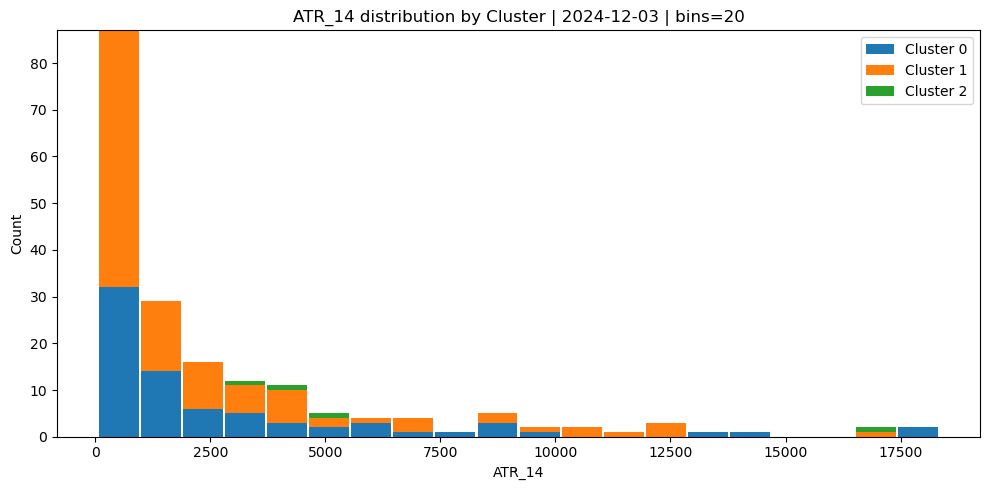

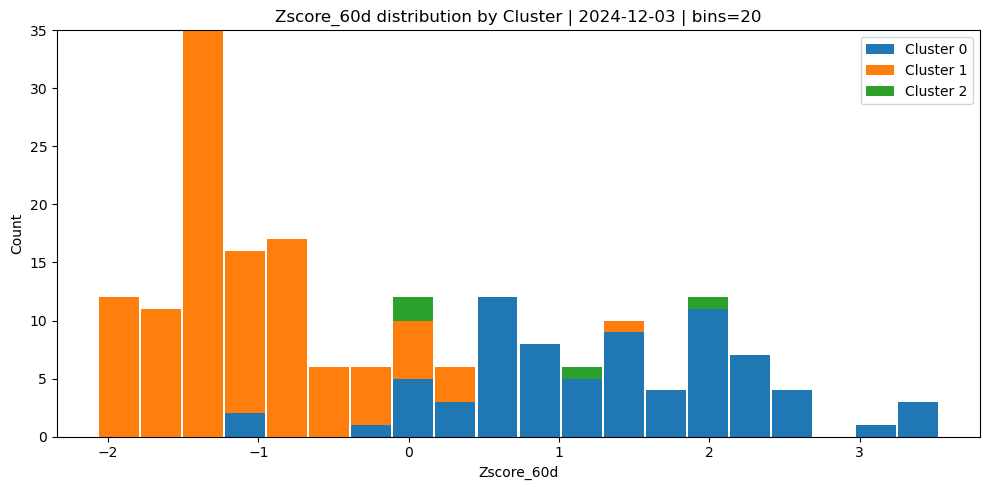

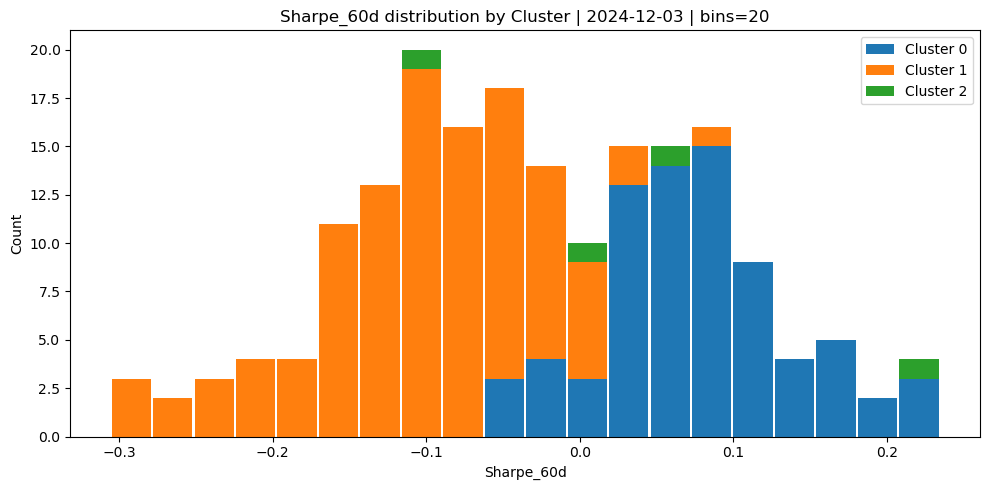

In [30]:
plot_cluster_histograms(
    df_cluster_nonnull,
    date="2024-12-03",
    cols=["ATR_14","Zscore_60d","Sharpe_60d"],
    bins=20,
    stacked=True
)
